In [66]:
# notebook globals
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

# get fights data
df = pd.read_csv('../tuf/fights.csv')
all_wins = df[df['outcome'] == "win"].copy()
win_total = len(all_wins)

# get sub data if sub type is given
subs = df[(df['method'] == 'SUB') & (df['method_details'] != 'N/A')].copy()
# make submission type more readable
subs['sub_type'] = subs['method_details'].str.title().str.replace('Naked', 'N.').str.replace('Choke', 'C.')

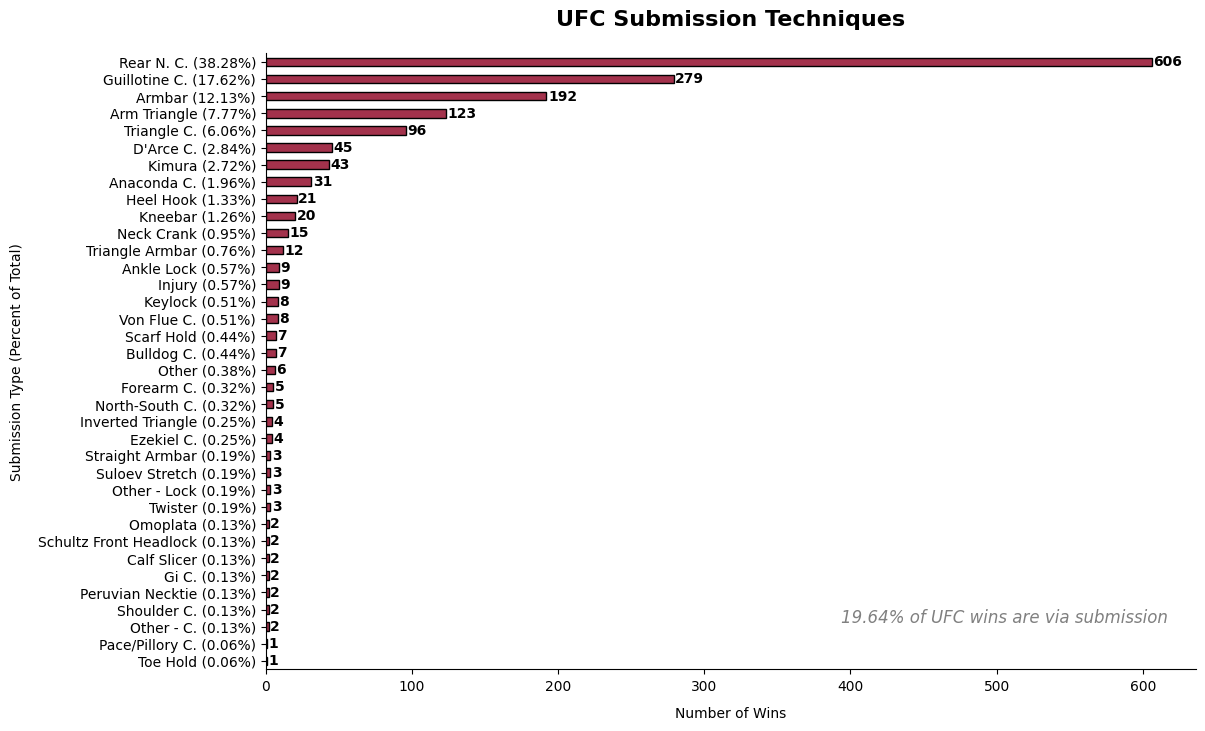

In [64]:
# plot for submission type
plt.figure(figsize=(12, 8))
# get number of wins for each type of submission, sorting by occurance
sub_counts = subs['sub_type'].value_counts().sort_values()
# total submissions in UFC history
sub_total = sub_counts.sum()

# create y label with percent next to submission name
y_labels = [f"{name} ({count/sub_total:.2%})" for name, count in zip(sub_counts.index, sub_counts)]

# populate graph
ax = sub_counts.plot(kind='barh', color='#a3324c', edgecolor='black')
ax.set_yticks(range(len(y_labels)))
ax.set_yticklabels(y_labels)

# create title / labels
plt.title('UFC Submission Techniques', pad=20, fontsize=16, fontweight='bold')
plt.xlabel('Number of Wins', labelpad=10)
plt.ylabel('Submission Type (Percent of Total)', labelpad=10)

# raw number of wins for each submission
total = sub_counts.sum()
for i, v in enumerate(sub_counts):
    ax.text(v + 1, i, f"{v}", color='black', va='center', fontsize=10, fontweight='bold')

# add subtitle
subtitle = f"{(sub_total/win_total * 100):.2f}% of UFC wins are via submission"
plt.text(
    0.97, .07,
    subtitle,
    transform=ax.transAxes,
    ha='right',
    va='bottom',
    fontsize=12,
    fontstyle='italic',
    color='gray'
)

# plot (not using 'tight_layout' to fully show the disparity)
sns.despine()
plt.show()

<Figure size 1600x900 with 0 Axes>

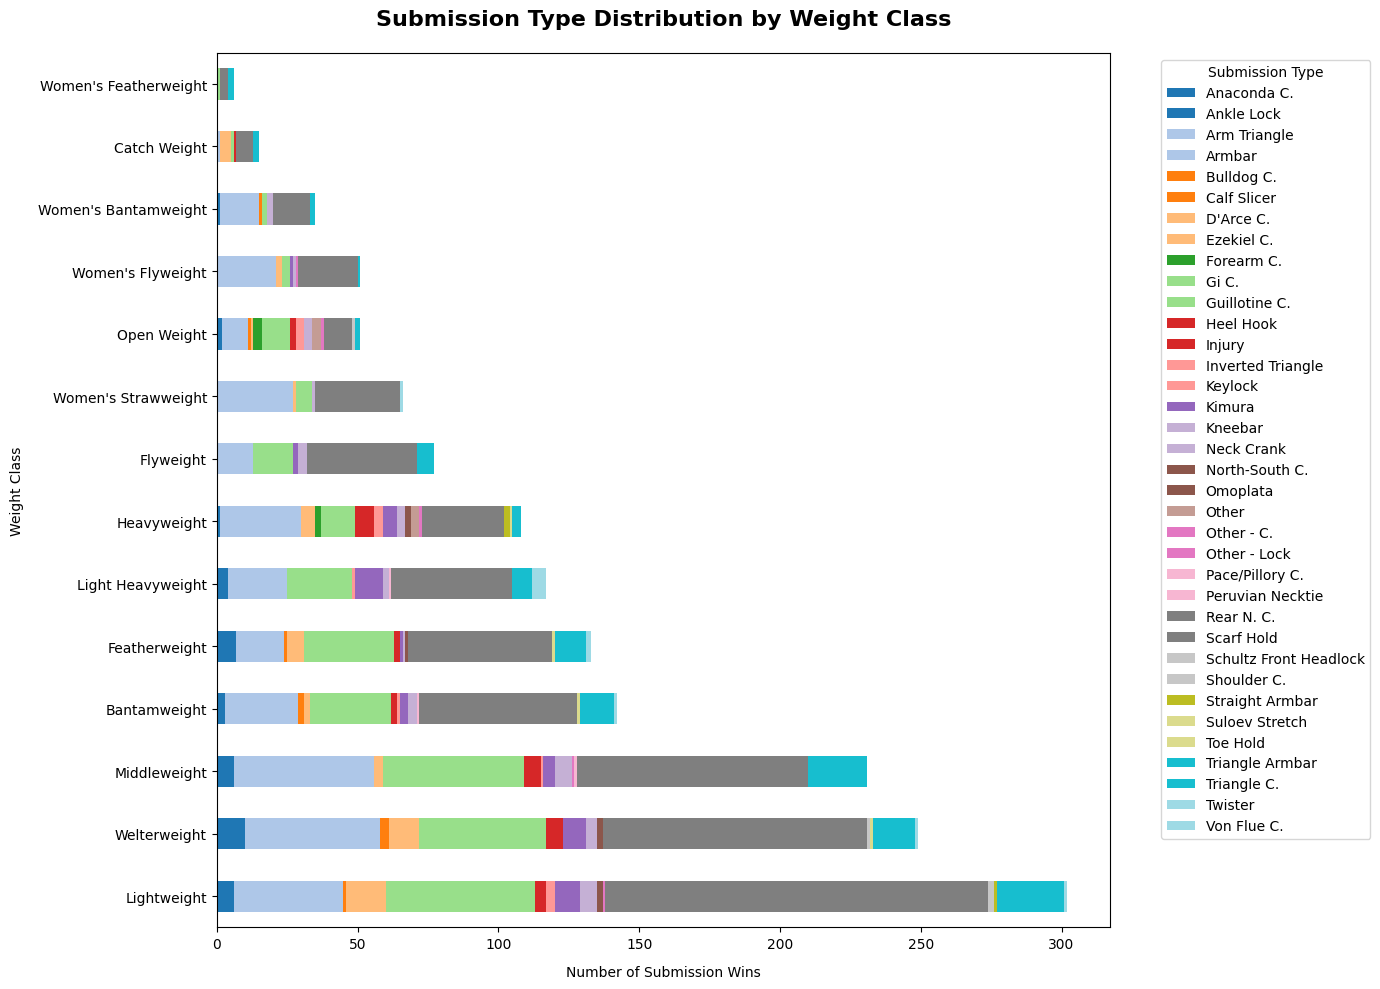

In [22]:
# create stacked bar chart for number of submission wins and type of submission by weightclass
plt.figure(figsize=(16, 9))
# group submission type by weight class
grouped = subs.groupby(['weight_class', 'sub_type']).size().reset_index(name='count')
pivot = grouped.pivot(index='weight_class', columns='sub_type', values='count').fillna(0)

# go from least to most subs
pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]
pivot.plot(kind='barh', stacked=True, figsize=(14, 10), colormap='tab20')

# create titles / labels
plt.title('Submission Type Distribution by Weight Class', pad=20, fontsize=16, fontweight='bold')
plt.xlabel('Number of Submission Wins', labelpad=10)
plt.ylabel('Weight Class', labelpad=10)
plt.legend(title='Submission Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# plot
plt.tight_layout()
plt.show()

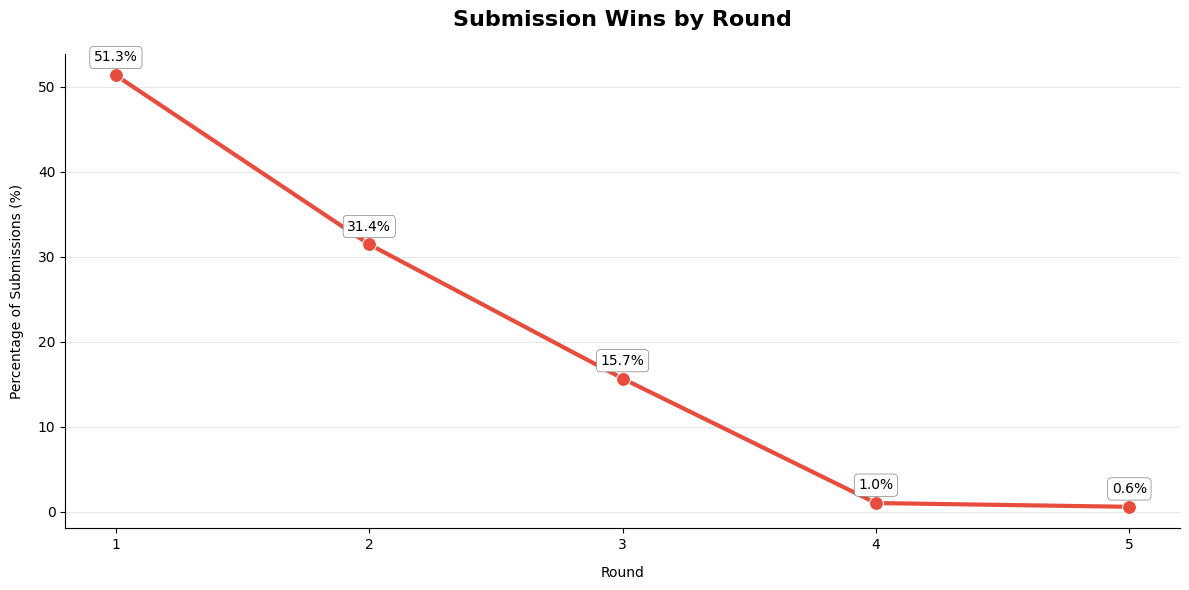

In [26]:
# line plot for which round contained a submission in fights won by submission
plt.figure(figsize=(12, 6))
# find the last round in fights won by submission
round_subs = subs['end_round'].value_counts(normalize=True).sort_index() * 100

# create line plot
ax = sns.lineplot(
    x=round_subs.index, 
    y=round_subs.values,
    marker='o',
    markersize=10,
    linewidth=3,
    color='#e74c3c'
)

# create titles / labels
plt.title('Submission Wins by Round', pad=20, fontsize=16, fontweight='bold')
plt.xlabel('Round', labelpad=10)
plt.ylabel('Percentage of Submissions (%)', labelpad=10)
plt.xticks(range(1, 6))
plt.grid(axis='y', alpha=0.3)

# add percentage on graph
for x, y in zip(round_subs.index, round_subs.values):
    ax.annotate(f'{y:.1f}%', (x, y), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center',
                fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray', lw=0.5))

# plot
sns.despine()
plt.tight_layout()
plt.show()